In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import torch
from scipy.special import softmax 
from sklearn.preprocessing import StandardScaler

import pyro
import pyro.distributions as dist
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal
from pyro.infer import MCMC, NUTS, HMC, SVI, Trace_ELBO
from pyro.optim import Adam, ClippedAdam

c:\Users\MNIS\Anaconda3\envs\ModelBasedML38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data Processing

In [2]:
scaler = StandardScaler()

In [3]:
#Use your own local path please!
path = "./Data/"
file_name = ["train.csv", "test.csv", "submission.csv"]
df_train = pd.read_csv(path + file_name[0])
df_test = pd.read_csv(path + file_name[1])
df_submission = pd.read_csv(path + file_name[2])

In [4]:
df_train['key'] = df_train['key'].fillna(df_train['key'].mean())

In [5]:
df_train['instrumentalness'] = df_train['instrumentalness'].fillna(df_train['instrumentalness'].mean())

In [6]:
df_train['Popularity'] = df_train['Popularity'].fillna(df_train['Popularity'].mean())

In [7]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [9]:
df_features = df_train[['Popularity', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo',
       'duration_in min/ms', 'time_signature']].copy()
df_features[df_features.columns] = scaler.fit_transform(df_features)

df_train_target = df_train[['Class']].sample(1000)
df_train_target_index = df_train_target.index
df_train_features = df_features.iloc[df_train_target_index].to_numpy()
df_train_target = df_train_target.to_numpy()

df_features_new = df_features
df_features_new[['Class']] = df_train[['Class']]
# df_features_new

df_rest_features = df_features_new.drop(index = df_train_target_index).reset_index()
# df_rest_target = df_train_target.iloc[~df_train_target_index].reset_index()
df_rest_features = df_rest_features.drop(columns = {df_rest_features.columns[0]})
df_test_target = df_rest_features[['Class']].sample(200)
df_test_target_index = df_test_target.index

df_test_features = df_rest_features.iloc[df_test_target_index]
df_test_features = df_test_features.drop(columns={'Class'}).to_numpy()

df_test_target = df_test_target.to_numpy()

# df_rest_features

In [41]:
D = df_train_features.shape[1]
N_train = df_train_features.shape[0]
N_test = df_test_features.shape[0]
n_cat = 11 

### Ancestral Sampling 

In [46]:
# sample coefficients (beta)
beta = np.random.normal(0,1,size=D)
print("beta:", beta)

beta_array = np.zeros((n_cat,D))

for i in range(n_cat):
    
    beta_array[i,:] = np.random.normal(0,1,size=D)
    
# sample observations (y's)
y = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(beta_array[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y[n,:] = np.random.multinomial(1, p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    #print('n, p and y ', n, p, y[n,:])

beta: [ 0.60262923  0.65426701  0.82838025  1.0210698  -0.48560548  0.03383782
  0.4041731  -0.8222166  -0.15726338  1.13588311 -0.25498028  0.61586114
  0.24394891 -1.73514037]


In [47]:
label_array = np.array([]) 
for i in y:
    label_array = np.append(label_array,np.argmax(i))


In [50]:
from collections import Counter

counts = Counter(label_array)
counts

Counter({7.0: 131,
         10.0: 85,
         2.0: 147,
         6.0: 59,
         0.0: 65,
         4.0: 104,
         8.0: 150,
         5.0: 52,
         3.0: 70,
         9.0: 57,
         1.0: 80})

In [51]:
print("Accuracy:", 1.0*np.sum(label_array == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.093


### Model implementation with Pyro

In [52]:
def model(X, n_cat, obs=None):
    input_dim = X.shape[1]
    alpha = pyro.sample("alpha", dist.Normal(torch.zeros(1, n_cat), 
                                             5.*torch.ones(1, n_cat)).to_event())  # Prior for the bias/intercept
    beta  = pyro.sample("beta", dist.Normal(torch.zeros(input_dim, n_cat), 
                                            5.*torch.ones(input_dim, n_cat)).to_event()) # Priors for the regression coeffcients
    
    with pyro.plate("data"):
        y = pyro.sample("y", dist.Categorical(logits=alpha + X.matmul(beta)), obs=obs)
        
    return y

In [53]:
X_train = torch.tensor(df_train_features).float()
y_train = torch.tensor(df_train_target.flatten()).float()

#### Model training 

In [18]:
# Define guide function
guide = AutoMultivariateNormal(model)

# Reset parameter values
pyro.clear_param_store()

# Define the number of optimization steps
n_steps = 20000

# Setup the optimizer
adam_params = {"lr": 0.001}
optimizer = ClippedAdam(adam_params)

# Setup the inference algorithm
elbo = Trace_ELBO(num_particles=1)
svi = SVI(model, guide, optimizer, loss=elbo)

# Do gradient steps
for step in range(n_steps):
    elbo = svi.step(X_train, n_cat, y_train)
    if step % 1000 == 0:
        print("[%d] ELBO: %.1f" % (step, elbo))

[0] ELBO: 10566.7
[1000] ELBO: 5102.8
[2000] ELBO: 2943.3
[3000] ELBO: 2121.1
[4000] ELBO: 1949.6
[5000] ELBO: 1896.4
[6000] ELBO: 1899.3
[7000] ELBO: 1869.1
[8000] ELBO: 1862.4
[9000] ELBO: 1854.6
[10000] ELBO: 1853.3
[11000] ELBO: 1845.4
[12000] ELBO: 1846.9
[13000] ELBO: 1843.5
[14000] ELBO: 1839.5
[15000] ELBO: 1845.0
[16000] ELBO: 1832.8
[17000] ELBO: 1836.7
[18000] ELBO: 1840.7
[19000] ELBO: 1831.3


In [54]:
from pyro.infer import Predictive

predictive = Predictive(model, guide=guide, num_samples=2000,
                        return_sites=("alpha", "beta"))
samples = predictive(X_train, n_cat, y_train)

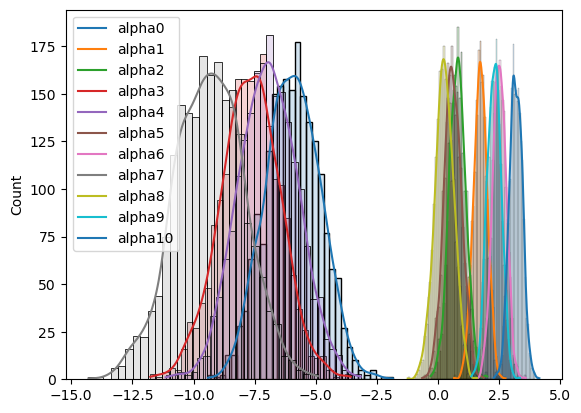

In [55]:
samples_alpha = samples["alpha"].detach().squeeze()
for c in range(n_cat):
    sns.histplot(samples_alpha[:,c], kde=True, alpha=0.2)
plt.legend(["alpha%d" % c for c in range(n_cat)])
plt.show()

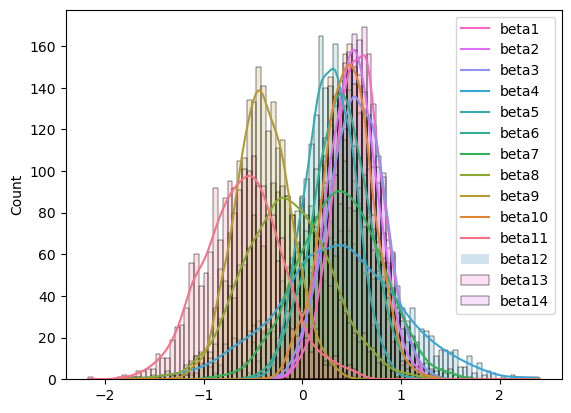

In [56]:
samples_beta = samples["beta"].detach().squeeze()
for c in range(1):
    sns.histplot(samples_beta[:,c], kde=True, alpha=0.2)
plt.legend(["beta%d" % int(int(c)+1) for c in range(D)])
plt.show()

In [57]:
mean_betas = samples_beta.mean(axis=0)
mean_betas = mean_betas.T

### Inference and computation of accuracy on the train dataset 

In [61]:
# sample observations (y's)
y_train_pred = np.zeros((N_train,n_cat))
for n in range(N_train):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(mean_betas[i,:], df_train_features[n,:]))])
        
    p =  softmax(probs)
    y_train_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_train_pred[n,:][0])

n, p and y  0 [0.10415661 0.01795775 0.04090596 0.00241518 0.75200261 0.00803284
 0.01652912 0.00993983 0.01941113 0.01071994 0.01792902] 4.0
n, p and y  1 [1.28389929e-02 4.26813379e-08 1.88358020e-08 7.20621122e-05
 3.54760303e-03 3.57279872e-08 1.28435455e-07 9.83540864e-01
 1.06165020e-08 1.34848209e-07 1.06515995e-07] 7.0
n, p and y  2 [0.00177043 0.07702305 0.0112975  0.00640989 0.00679022 0.08221347
 0.05031963 0.04162739 0.45091651 0.06642011 0.2052118 ] 8.0
n, p and y  3 [3.11221048e-04 1.67150430e-02 9.31199202e-04 9.26458673e-05
 9.57409412e-06 5.53424928e-03 3.20717727e-02 2.45547083e-03
 9.38745322e-01 1.10656554e-03 2.02693594e-03] 8.0
n, p and y  4 [3.75673094e-01 6.73091686e-07 1.08090332e-05 2.28378666e-02
 3.36943124e-01 1.10045215e-06 2.66270383e-06 2.64519065e-01
 3.11063703e-07 7.11121358e-06 4.18248716e-06] 0.0
n, p and y  5 [4.40655555e-04 6.29598490e-02 1.17336252e-02 1.15700989e-03
 8.83031913e-05 2.40040518e-02 6.21809492e-02 6.08261468e-03
 7.99437985e-01 1.4

n, p and y  515 [0.08404706 0.01698546 0.00956602 0.10798376 0.00125716 0.03875126
 0.06340024 0.30623402 0.30037643 0.0492976  0.02210099] 7.0
n, p and y  516 [2.10595239e-03 1.33228221e-02 6.01910438e-01 2.53280884e-01
 5.79874326e-02 2.25024586e-02 1.19396219e-02 7.09108739e-05
 7.13198858e-04 2.93165385e-02 6.84974262e-03] 2.0
n, p and y  517 [1.67069427e-05 7.98034732e-02 5.90914702e-02 5.93364074e-05
 3.02872108e-06 1.72768034e-02 4.31671886e-02 1.51419262e-04
 7.41017660e-01 6.10640199e-03 5.33065111e-02] 8.0
n, p and y  518 [2.50261116e-02 9.51635779e-02 9.10949918e-02 7.59737894e-05
 7.87299956e-02 8.82728376e-03 9.21973103e-02 4.42965607e-02
 4.98821756e-01 6.53614340e-03 5.92302950e-02] 8.0
n, p and y  519 [5.82226208e-06 6.46739052e-02 2.55880042e-02 1.18041666e-02
 1.95533513e-07 8.52924595e-01 1.14975531e-02 4.60616258e-08
 8.32654224e-03 1.91728958e-02 6.00627456e-03] 5.0
n, p and y  520 [1.32794130e-02 6.28653553e-03 6.13326399e-04 5.60054631e-03
 4.02508505e-02 1.82704

In [62]:
y_train_pred = y_train_pred[:,0]

In [64]:
df_train_target.flatten()

array([10,  7, 10,  8,  4,  6, 10, 10,  1,  6, 10,  7,  2,  6, 10, 10, 10,
        9, 10,  1,  9,  5,  9, 10, 10,  9,  7,  9,  5,  2,  6,  9,  8,  0,
        2,  8,  9,  8,  5, 10,  9,  1,  8,  8,  3,  8, 10, 10,  7,  9,  5,
        2, 10,  9, 10,  2,  1,  6,  6, 10,  9,  3, 10, 10,  9, 10,  6,  6,
       10, 10,  7,  5,  6,  1,  9,  5, 10, 10, 10,  9,  6,  8, 10,  6, 10,
        6,  2, 10,  5,  8,  2, 10,  8,  8,  4,  2,  3, 10,  2,  9,  9,  8,
        8,  8,  9,  2,  2,  3, 10,  5,  9, 10, 10,  1,  6,  5, 10, 10,  9,
        1, 10,  5,  9,  9,  6, 10,  6, 10,  6, 10,  8, 10,  9,  2,  6,  6,
        6,  6, 10,  8,  1,  2,  8,  9,  9,  2, 10, 10, 10, 10,  2,  1,  6,
       10,  8,  8,  2, 10,  8,  6,  9,  4, 10, 10,  8, 10,  1,  6,  1,  8,
       10,  6, 10,  9,  8, 10,  1, 10, 10,  1, 10, 10,  6,  6,  2,  6,  9,
        8,  2,  6,  0,  8,  5,  2, 10,  9,  5,  9,  3,  5,  9,  1,  2,  4,
        6,  0,  0, 10,  8,  8,  6,  6,  1,  8, 10,  8, 10, 10, 10,  9,  7,
        5, 10,  5,  1,  1

In [65]:
print("Accuracy:", 1.0*np.sum(y_train_pred == df_train_target.flatten()) / len(df_train_target))

Accuracy: 0.233


### Inference and computation of accuracy on the test dataset 

In [66]:
# sample observations (y's)
y_test_pred = np.zeros((N_test,n_cat))
for n in range(N_test):
    
    probs = np.zeros(n_cat)
    for i in range(n_cat):
        probs[i] = np.array([(np.dot(mean_betas[i,:], df_test_features[n,:]))])
        
    p =  softmax(probs)
    y_test_pred[n,:] = np.argmax(p)  #binomial with one trial is equivalent to bernoulli
    #y[n] = int(p > 0.5) # alternative version without observation noise
    #print(" p=, y[n]="  (n, p, y[n,:]))
    print('n, p and y ', n, p, y_test_pred[n,:])

n, p and y  0 [2.50335766e-06 1.55637581e-02 2.01614228e-03 2.84801342e-07
 2.03654533e-07 9.33785070e-04 7.78783252e-03 2.42949422e-06
 9.70159652e-01 1.58307748e-04 3.37510098e-03] [8. 8. 8. 8. 8. 8. 8. 8. 8. 8. 8.]
n, p and y  1 [0.00125087 0.02242703 0.01386807 0.00162096 0.8732884  0.01244314
 0.013538   0.00123417 0.00795377 0.03200987 0.02036572] [4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
n, p and y  2 [3.35011238e-02 5.20215719e-08 5.98028020e-06 9.61182133e-01
 5.01138379e-03 1.21893887e-07 5.19728719e-08 2.98022927e-04
 8.18040405e-10 8.24068917e-07 3.05715823e-07] [3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
n, p and y  3 [4.74443146e-06 2.62865737e-02 8.64953150e-01 2.38953431e-07
 9.49564922e-04 1.55049196e-02 2.93121043e-02 2.40103647e-05
 2.86260399e-02 1.17587056e-02 2.25799480e-02] [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
n, p and y  4 [2.10220740e-02 6.47562214e-02 5.95500788e-02 4.27915888e-02
 4.76141001e-01 3.02068959e-02 3.47452716e-02 4.25553173e-05
 1.45306349e-01 7.41491563e-02 5.1288

In [67]:
y_test_pred = y_test_pred[:,0]

In [68]:
print("Accuracy:", 1.0*np.sum(y_test_pred == df_test_target.flatten()) / len(df_test_target))

Accuracy: 0.235



DOUBLE CHECK

* fillna using KNN inputer 
* is averaging the betas giving the best result for the predictions 
* is ancentral sampling correct? 

TODO

* Have priors for mean and variance for betas and alphas - parameter tuning 
* Consider different distributions for priors
* Train model on more data - currently 100 
* Extend it with FFNN 
* Feature engineer name and album name and retrain logistic regression model using these attributes